In [1]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset,Dataset
from torch.nn.modules.conv import Conv2d 
import torch.nn.functional as F
from torch.nn.modules.batchnorm import BatchNorm2d
import time
import numpy as np
import matplotlib.pyplot as plt
import os
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [3]:
model = Net() 
model=model.to(device)
# print(model)

In [4]:
shapeness1=np.load('/home/chase/Boyka/Lyu/data/shapeness/origin/rainfall_img256_sharpness1_unit8.npz')
data=shapeness1['data'][:,-1]
label=shapeness1['rainfall']
# data=np.load('/home/chase/Boyka/Lyu/data/rainfall/reg/data_reg_2000.npy')
data=np.expand_dims(data,axis=1)
# data=torch.from_numpy(data)
data=torch.FloatTensor(data)
# print(type(data[0][0][0]))
# print(data[0][0][0])
# label=np.load('/home/chase/Boyka/Lyu/data/rainfall/reg/label_reg_2000.npy')
print(label.shape)
label=np.expand_dims(label,axis=1)
# label=torch.from_numpy(label)
label=torch.FloatTensor(label)
# print(label[0][0][0])
# print(data.shape,label.shape)
train_x=data[:-20]
test_x=data[-20:]
train_y=label[:-20]
test_y=label[-20:]
print(data.shape,label.shape)

(100, 8, 8)
torch.Size([100, 1, 256, 256]) torch.Size([100, 1, 8, 8])


In [5]:
train_dataset = TensorDataset(train_x,train_y)
test_dataset = TensorDataset(test_x,test_y)
train_loader=DataLoader(dataset=train_dataset,batch_size=32,shuffle=True,num_workers=2)
test_loader=DataLoader(dataset=test_dataset,batch_size=32,shuffle=True,num_workers=2)
train_data_size=len(train_loader)
valid_data_size=len(test_loader)

In [6]:
for epoch in range(1):
    for i,data in enumerate(train_loader):
        inputs, label=data
#         print("epoch：", epoch, "的第" , i, "个inputs", inputs.data.size(), "labels", labels.data.size())
        print(len(data))
        print(data[0].shape)
        print(inputs.shape)
        print(label.shape)
        print(type(data[0][0][0][0]))
        break
        
        

2
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 8, 8])
<class 'torch.Tensor'>


In [7]:
def train_and_valid(model, loss_function, optimizer, epochs=25):
    
    history = []
    best_error = float('inf')
    best_epoch = 0
    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        model.train()
        train_loss = 0.0
        train_error = 0.0
        valid_loss = 0.0
        valid_error = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += torch.mean(loss).item() 
            
            train_error+=torch.mean(torch.abs(outputs-labels)).item()
 
        with torch.no_grad():
            model.eval()
            for j, (inputs, labels) in enumerate(test_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                valid_loss += torch.mean(loss).item() 
                
                valid_error+=torch.mean(torch.abs(outputs-labels)).item()
 
 
        avg_train_loss = train_loss/train_data_size
        avg_train_error = train_error/train_data_size
 
        avg_valid_loss = valid_loss/valid_data_size
        avg_valid_error = valid_error/valid_data_size
 
        history.append([avg_train_loss, avg_valid_loss, avg_train_error, avg_valid_error])
 
        if best_error > avg_valid_error:
            best_error = avg_valid_error
            best_epoch = epoch + 1
 
        epoch_end = time.time()
 
        print("Training: Loss: {:.4f}, MAE: {:.4f}, \nValidation: Loss: {:.4f}, MAE: {:.4f}, \nTime: {:.4f}s".format(avg_train_loss, avg_train_error, avg_valid_loss, avg_valid_error, epoch_end-epoch_start
        ))
        print("Best Error for validation : {:.4f} at epoch {:03d}".format(best_error, best_epoch))
        if epoch%20==0:
            torch.save(model, 'models/'+'rivers_model_'+str(epoch+1)+'.pt')
    return model, history


In [8]:
print(model)

Net(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv4): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv5): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv6): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)


In [9]:
loss_func=nn.MSELoss()
num_epochs=500
optimizer = optim.Adam(model.parameters())


trained_model, history = train_and_valid(model, loss_func, optimizer, num_epochs)
torch.save(trained_model, 'models/'+'best_model.pt')
 


Epoch: 1/500


/home/chase/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Training: Loss: 27.1727, MAE: 3.6491, 
Validation: Loss: 3.0646, MAE: 1.6504, 
Time: 0.7018s
Best Error for validation : 1.6504 at epoch 001
Epoch: 2/500
Training: Loss: 1.1549, MAE: 0.7892, 
Validation: Loss: 0.1306, MAE: 0.2966, 
Time: 0.3329s
Best Error for validation : 0.2966 at epoch 002
Epoch: 3/500
Training: Loss: 0.1399, MAE: 0.3047, 
Validation: Loss: 0.1254, MAE: 0.2917, 
Time: 0.3349s
Best Error for validation : 0.2917 at epoch 003
Epoch: 4/500
Training: Loss: 0.1117, MAE: 0.2780, 
Validation: Loss: 0.1044, MAE: 0.2717, 
Time: 0.3398s
Best Error for validation : 0.2717 at epoch 004
Epoch: 5/500
Training: Loss: 0.0997, MAE: 0.2649, 
Validation: Loss: 0.0989, MAE: 0.2618, 
Time: 0.3390s
Best Error for validation : 0.2618 at epoch 005
Epoch: 6/500
Training: Loss: 0.0936, MAE: 0.2585, 
Validation: Loss: 0.0958, MAE: 0.2619, 
Time: 0.3392s
Best Error for validation : 0.2618 at epoch 005
Epoch: 7/500
Training: Loss: 0.0936, MAE: 0.2593, 
Validation: Loss: 0.0922, MAE: 0.2556, 
Tim

Training: Loss: 0.0581, MAE: 0.2001, 
Validation: Loss: 0.0640, MAE: 0.2075, 
Time: 0.3333s
Best Error for validation : 0.2073 at epoch 050
Epoch: 56/500
Training: Loss: 0.0564, MAE: 0.1966, 
Validation: Loss: 0.0639, MAE: 0.2100, 
Time: 0.3350s
Best Error for validation : 0.2073 at epoch 050
Epoch: 57/500
Training: Loss: 0.0565, MAE: 0.1965, 
Validation: Loss: 0.0614, MAE: 0.2041, 
Time: 0.3398s
Best Error for validation : 0.2041 at epoch 057
Epoch: 58/500
Training: Loss: 0.0543, MAE: 0.1917, 
Validation: Loss: 0.0661, MAE: 0.2134, 
Time: 0.3393s
Best Error for validation : 0.2041 at epoch 057
Epoch: 59/500
Training: Loss: 0.0551, MAE: 0.1943, 
Validation: Loss: 0.0625, MAE: 0.2068, 
Time: 0.3353s
Best Error for validation : 0.2041 at epoch 057
Epoch: 60/500
Training: Loss: 0.0533, MAE: 0.1904, 
Validation: Loss: 0.0619, MAE: 0.2035, 
Time: 0.3366s
Best Error for validation : 0.2035 at epoch 060
Epoch: 61/500
Training: Loss: 0.0537, MAE: 0.1905, 
Validation: Loss: 0.0621, MAE: 0.2035,

Training: Loss: 0.0231, MAE: 0.1214, 
Validation: Loss: 0.0569, MAE: 0.1896, 
Time: 0.3394s
Best Error for validation : 0.1886 at epoch 091
Epoch: 110/500
Training: Loss: 0.0220, MAE: 0.1183, 
Validation: Loss: 0.0619, MAE: 0.1975, 
Time: 0.3390s
Best Error for validation : 0.1886 at epoch 091
Epoch: 111/500
Training: Loss: 0.0227, MAE: 0.1198, 
Validation: Loss: 0.0581, MAE: 0.1902, 
Time: 0.3375s
Best Error for validation : 0.1886 at epoch 091
Epoch: 112/500
Training: Loss: 0.0219, MAE: 0.1186, 
Validation: Loss: 0.0567, MAE: 0.1885, 
Time: 0.3370s
Best Error for validation : 0.1885 at epoch 112
Epoch: 113/500
Training: Loss: 0.0212, MAE: 0.1156, 
Validation: Loss: 0.0594, MAE: 0.1938, 
Time: 0.3432s
Best Error for validation : 0.1885 at epoch 112
Epoch: 114/500
Training: Loss: 0.0212, MAE: 0.1160, 
Validation: Loss: 0.0580, MAE: 0.1901, 
Time: 0.3392s
Best Error for validation : 0.1885 at epoch 112
Epoch: 115/500
Training: Loss: 0.0214, MAE: 0.1162, 
Validation: Loss: 0.0581, MAE: 0

Training: Loss: 0.0104, MAE: 0.0803, 
Validation: Loss: 0.0656, MAE: 0.1994, 
Time: 0.3420s
Best Error for validation : 0.1885 at epoch 112
Epoch: 163/500
Training: Loss: 0.0113, MAE: 0.0840, 
Validation: Loss: 0.0690, MAE: 0.2048, 
Time: 0.3417s
Best Error for validation : 0.1885 at epoch 112
Epoch: 164/500
Training: Loss: 0.0118, MAE: 0.0863, 
Validation: Loss: 0.0655, MAE: 0.1976, 
Time: 0.3416s
Best Error for validation : 0.1885 at epoch 112
Epoch: 165/500
Training: Loss: 0.0111, MAE: 0.0828, 
Validation: Loss: 0.0654, MAE: 0.1973, 
Time: 0.3412s
Best Error for validation : 0.1885 at epoch 112
Epoch: 166/500
Training: Loss: 0.0105, MAE: 0.0809, 
Validation: Loss: 0.0672, MAE: 0.2026, 
Time: 0.3417s
Best Error for validation : 0.1885 at epoch 112
Epoch: 167/500
Training: Loss: 0.0102, MAE: 0.0794, 
Validation: Loss: 0.0654, MAE: 0.1975, 
Time: 0.3409s
Best Error for validation : 0.1885 at epoch 112
Epoch: 168/500
Training: Loss: 0.0095, MAE: 0.0766, 
Validation: Loss: 0.0663, MAE: 0

Training: Loss: 0.0050, MAE: 0.0545, 
Validation: Loss: 0.0722, MAE: 0.2059, 
Time: 0.3417s
Best Error for validation : 0.1885 at epoch 112
Epoch: 216/500
Training: Loss: 0.0055, MAE: 0.0573, 
Validation: Loss: 0.0747, MAE: 0.2116, 
Time: 0.3411s
Best Error for validation : 0.1885 at epoch 112
Epoch: 217/500
Training: Loss: 0.0054, MAE: 0.0566, 
Validation: Loss: 0.0729, MAE: 0.2074, 
Time: 0.3414s
Best Error for validation : 0.1885 at epoch 112
Epoch: 218/500
Training: Loss: 0.0053, MAE: 0.0563, 
Validation: Loss: 0.0725, MAE: 0.2088, 
Time: 0.3415s
Best Error for validation : 0.1885 at epoch 112
Epoch: 219/500
Training: Loss: 0.0052, MAE: 0.0561, 
Validation: Loss: 0.0742, MAE: 0.2112, 
Time: 0.3415s
Best Error for validation : 0.1885 at epoch 112
Epoch: 220/500
Training: Loss: 0.0051, MAE: 0.0555, 
Validation: Loss: 0.0741, MAE: 0.2087, 
Time: 0.3436s
Best Error for validation : 0.1885 at epoch 112
Epoch: 221/500
Training: Loss: 0.0051, MAE: 0.0554, 
Validation: Loss: 0.0724, MAE: 0

Training: Loss: 0.0026, MAE: 0.0390, 
Validation: Loss: 0.0776, MAE: 0.2135, 
Time: 0.3436s
Best Error for validation : 0.1885 at epoch 112
Epoch: 269/500
Training: Loss: 0.0026, MAE: 0.0392, 
Validation: Loss: 0.0777, MAE: 0.2133, 
Time: 0.3394s
Best Error for validation : 0.1885 at epoch 112
Epoch: 270/500
Training: Loss: 0.0026, MAE: 0.0396, 
Validation: Loss: 0.0787, MAE: 0.2150, 
Time: 0.3437s
Best Error for validation : 0.1885 at epoch 112
Epoch: 271/500
Training: Loss: 0.0027, MAE: 0.0404, 
Validation: Loss: 0.0769, MAE: 0.2122, 
Time: 0.3414s
Best Error for validation : 0.1885 at epoch 112
Epoch: 272/500
Training: Loss: 0.0024, MAE: 0.0378, 
Validation: Loss: 0.0773, MAE: 0.2129, 
Time: 0.3396s
Best Error for validation : 0.1885 at epoch 112
Epoch: 273/500
Training: Loss: 0.0023, MAE: 0.0371, 
Validation: Loss: 0.0787, MAE: 0.2145, 
Time: 0.3417s
Best Error for validation : 0.1885 at epoch 112
Epoch: 274/500
Training: Loss: 0.0026, MAE: 0.0389, 
Validation: Loss: 0.0777, MAE: 0

Training: Loss: 0.0015, MAE: 0.0297, 
Validation: Loss: 0.0796, MAE: 0.2155, 
Time: 0.3411s
Best Error for validation : 0.1885 at epoch 112
Epoch: 322/500
Training: Loss: 0.0014, MAE: 0.0285, 
Validation: Loss: 0.0805, MAE: 0.2171, 
Time: 0.3424s
Best Error for validation : 0.1885 at epoch 112
Epoch: 323/500
Training: Loss: 0.0016, MAE: 0.0306, 
Validation: Loss: 0.0804, MAE: 0.2169, 
Time: 0.3409s
Best Error for validation : 0.1885 at epoch 112
Epoch: 324/500
Training: Loss: 0.0014, MAE: 0.0287, 
Validation: Loss: 0.0804, MAE: 0.2167, 
Time: 0.3395s
Best Error for validation : 0.1885 at epoch 112
Epoch: 325/500
Training: Loss: 0.0016, MAE: 0.0308, 
Validation: Loss: 0.0815, MAE: 0.2181, 
Time: 0.3418s
Best Error for validation : 0.1885 at epoch 112
Epoch: 326/500
Training: Loss: 0.0017, MAE: 0.0314, 
Validation: Loss: 0.0804, MAE: 0.2180, 
Time: 0.3413s
Best Error for validation : 0.1885 at epoch 112
Epoch: 327/500
Training: Loss: 0.0016, MAE: 0.0311, 
Validation: Loss: 0.0794, MAE: 0

Training: Loss: 0.0016, MAE: 0.0310, 
Validation: Loss: 0.0816, MAE: 0.2189, 
Time: 0.3417s
Best Error for validation : 0.1885 at epoch 112
Epoch: 375/500
Training: Loss: 0.0017, MAE: 0.0315, 
Validation: Loss: 0.0812, MAE: 0.2183, 
Time: 0.3416s
Best Error for validation : 0.1885 at epoch 112
Epoch: 376/500
Training: Loss: 0.0015, MAE: 0.0299, 
Validation: Loss: 0.0825, MAE: 0.2202, 
Time: 0.3412s
Best Error for validation : 0.1885 at epoch 112
Epoch: 377/500
Training: Loss: 0.0017, MAE: 0.0321, 
Validation: Loss: 0.0821, MAE: 0.2198, 
Time: 0.3412s
Best Error for validation : 0.1885 at epoch 112
Epoch: 378/500
Training: Loss: 0.0015, MAE: 0.0299, 
Validation: Loss: 0.0797, MAE: 0.2156, 
Time: 0.3418s
Best Error for validation : 0.1885 at epoch 112
Epoch: 379/500
Training: Loss: 0.0016, MAE: 0.0312, 
Validation: Loss: 0.0803, MAE: 0.2166, 
Time: 0.3414s
Best Error for validation : 0.1885 at epoch 112
Epoch: 380/500
Training: Loss: 0.0014, MAE: 0.0297, 
Validation: Loss: 0.0823, MAE: 0

Training: Loss: 0.0015, MAE: 0.0305, 
Validation: Loss: 0.0813, MAE: 0.2192, 
Time: 0.3415s
Best Error for validation : 0.1885 at epoch 112
Epoch: 428/500
Training: Loss: 0.0017, MAE: 0.0322, 
Validation: Loss: 0.0811, MAE: 0.2169, 
Time: 0.3413s
Best Error for validation : 0.1885 at epoch 112
Epoch: 429/500
Training: Loss: 0.0012, MAE: 0.0267, 
Validation: Loss: 0.0801, MAE: 0.2164, 
Time: 0.3417s
Best Error for validation : 0.1885 at epoch 112
Epoch: 430/500
Training: Loss: 0.0014, MAE: 0.0300, 
Validation: Loss: 0.0809, MAE: 0.2186, 
Time: 0.3414s
Best Error for validation : 0.1885 at epoch 112
Epoch: 431/500
Training: Loss: 0.0010, MAE: 0.0249, 
Validation: Loss: 0.0811, MAE: 0.2179, 
Time: 0.3437s
Best Error for validation : 0.1885 at epoch 112
Epoch: 432/500
Training: Loss: 0.0009, MAE: 0.0236, 
Validation: Loss: 0.0805, MAE: 0.2177, 
Time: 0.3372s
Best Error for validation : 0.1885 at epoch 112
Epoch: 433/500
Training: Loss: 0.0008, MAE: 0.0219, 
Validation: Loss: 0.0815, MAE: 0

Training: Loss: 0.0010, MAE: 0.0238, 
Validation: Loss: 0.0816, MAE: 0.2202, 
Time: 0.3415s
Best Error for validation : 0.1885 at epoch 112
Epoch: 481/500
Training: Loss: 0.0010, MAE: 0.0249, 
Validation: Loss: 0.0814, MAE: 0.2186, 
Time: 0.3412s
Best Error for validation : 0.1885 at epoch 112
Epoch: 482/500
Training: Loss: 0.0010, MAE: 0.0251, 
Validation: Loss: 0.0806, MAE: 0.2176, 
Time: 0.3397s
Best Error for validation : 0.1885 at epoch 112
Epoch: 483/500
Training: Loss: 0.0007, MAE: 0.0201, 
Validation: Loss: 0.0810, MAE: 0.2181, 
Time: 0.3396s
Best Error for validation : 0.1885 at epoch 112
Epoch: 484/500
Training: Loss: 0.0007, MAE: 0.0213, 
Validation: Loss: 0.0813, MAE: 0.2183, 
Time: 0.3414s
Best Error for validation : 0.1885 at epoch 112
Epoch: 485/500
Training: Loss: 0.0006, MAE: 0.0195, 
Validation: Loss: 0.0813, MAE: 0.2182, 
Time: 0.3415s
Best Error for validation : 0.1885 at epoch 112
Epoch: 486/500
Training: Loss: 0.0005, MAE: 0.0178, 
Validation: Loss: 0.0817, MAE: 0

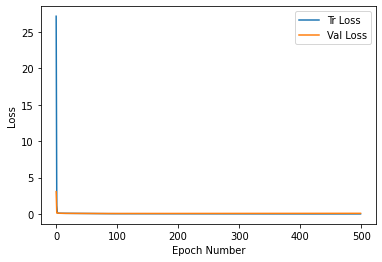

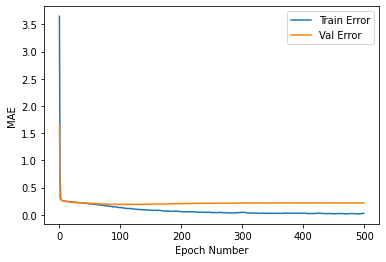

In [10]:
history = np.array(history)
plt.plot(history[:, 0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
# plt.ylim(0, 1)
plt.savefig('loss_curve.png')
plt.show()
 
plt.plot(history[:, 2:4])
plt.legend(['Train Error', 'Val Error'])
plt.xlabel('Epoch Number')
plt.ylabel('MAE')
# plt.ylim(0, 1)
plt.savefig('error_curve.png')
plt.show()

AttributeError: 'list' object has no attribute 'shape'

In [24]:
result=model(test_sample)
result

tensor([[[[0.5631, 0.1613, 0.2831, 0.1240, 0.8366, 0.5690, 0.7362, 0.4886],
          [0.0742, 0.9606, 0.4491, 0.4479, 0.6530, 0.5563, 0.1661, 0.4700],
          [0.5010, 0.6659, 0.5144, 0.3786, 0.7997, 0.0676, 0.6715, 0.7638],
          [0.0919, 0.0576, 0.5811, 0.3686, 0.8451, 0.2421, 0.0748, 0.8471],
          [0.6665, 0.0609, 0.0922, 0.0808, 0.6040, 0.8294, 0.3668, 0.0388],
          [0.8125, 0.7152, 0.5228, 0.8383, 0.3344, 0.7030, 0.4074, 0.5135],
          [0.6818, 0.2215, 0.6831, 0.5449, 0.5332, 0.6988, 0.5042, 0.5323],
          [0.2559, 0.6910, 0.2404, 0.8101, 0.6730, 0.6057, 0.1841, 0.7367]]]],
       device='cuda:0', grad_fn=<CudnnConvolutionBackward>)

In [26]:
result_sample=torch.unsqueeze(test_y[0],0).to(device)

In [27]:
result_sample

tensor([[[[0.6125, 0.1979, 0.2406, 0.1793, 0.8570, 0.5676, 0.6852, 0.4797],
          [0.0252, 0.9620, 0.4662, 0.4342, 0.5943, 0.5465, 0.0063, 0.4676],
          [0.3534, 0.7350, 0.4841, 0.4371, 0.8043, 0.1661, 0.6479, 0.6845],
          [0.0677, 0.0090, 0.5210, 0.4059, 0.7147, 0.2345, 0.0966, 0.7759],
          [0.5437, 0.2324, 0.0677, 0.1109, 0.7154, 0.7373, 0.4614, 0.0300],
          [0.8700, 0.7075, 0.4881, 0.9723, 0.4534, 0.6483, 0.3494, 0.5438],
          [0.6012, 0.1513, 0.7136, 0.3365, 0.5521, 0.9445, 0.4872, 0.5929],
          [0.2073, 0.6932, 0.2435, 0.9906, 0.8046, 0.4374, 0.2315, 0.7283]]]],
       device='cuda:0')

In [28]:
result_sample-result

tensor([[[[ 0.0495,  0.0366, -0.0426,  0.0553,  0.0203, -0.0014, -0.0511,
           -0.0089],
          [-0.0490,  0.0014,  0.0172, -0.0137, -0.0586, -0.0098, -0.1598,
           -0.0024],
          [-0.1476,  0.0691, -0.0304,  0.0585,  0.0046,  0.0985, -0.0235,
           -0.0793],
          [-0.0242, -0.0486, -0.0601,  0.0373, -0.1304, -0.0076,  0.0218,
           -0.0712],
          [-0.1228,  0.1716, -0.0245,  0.0301,  0.1114, -0.0922,  0.0946,
           -0.0089],
          [ 0.0575, -0.0077, -0.0346,  0.1340,  0.1190, -0.0547, -0.0580,
            0.0302],
          [-0.0806, -0.0702,  0.0305, -0.2084,  0.0189,  0.2457, -0.0170,
            0.0606],
          [-0.0486,  0.0022,  0.0031,  0.1805,  0.1316, -0.1683,  0.0474,
           -0.0084]]]], device='cuda:0', grad_fn=<SubBackward0>)

In [29]:
history[-1]

array([9.16668803e-05, 1.10731925e-02, 7.42801220e-03, 7.17941964e-02])